In [16]:
import sys

import numpy as np
import pandas as pd

from typing import List
from abc import ABC, abstractmethod
from sortedcontainers import SortedList
from scipy.spatial import distance_matrix
from scipy.stats import pearsonr
from matplotlib import pyplot as plt

sys.path.insert(1, '../utils')
from utils import *


In [17]:
a=pd.read_csv('../data/TSPA.csv', sep=';', header=None)
b=pd.read_csv('../data/TSPB.csv', sep=';', header=None)
tspa=pd.DataFrame(data=a.values, columns=['x', 'y', 'val'])
tspb=pd.DataFrame(data=b.values, columns=['x', 'y', 'val'])
coordinates=tspa[['x', 'y']].values
coordinatesb=tspb[['x', 'y']].values
dist=distance_matrix(coordinates, coordinates)
dist=np.round(dist)
distb=distance_matrix(coordinatesb, coordinatesb)
distb=np.round(distb)
costs=tspa[['val']].values
costsb=tspb[['val']].values

In [18]:
def node_similarity(solution1: List[int], solution2: List[int]):
    s1 = set(solution1)
    s2 = set(solution2)
    s = s1.intersection(s2)
    return len(s)

def edge_similarity(solution1: List[int], solution2: List[int]):
    count = 0
    for node1, node2 in zip(solution1, solution1[1:] + [solution1[0]]):
        try:
            ind = solution2.index(node1)
            ind1 = (ind - 1) % len(solution1)
            ind2 = (ind + 1) % len(solution1)
            if solution2[ind1] == node2 or solution2[ind2] == node2:
                count += 1
        except ValueError:
            pass
    return count

In [19]:
class Neighborhood(ABC):
    @abstractmethod
    def neighborhood_size(self):
        pass

    @abstractmethod
    def get_difference(self, ind, solution: List[int], unselected):
        pass

    @abstractmethod
    def modify_solution(self, ind, solution: List[int], unselected):
        pass


In [20]:
class EdgeNeighborhood(Neighborhood):
    def __init__(self, distance_matrix: np.ndarray, costs: np.ndarray, n) -> None:
        self.distance_matrix = distance_matrix
        self.costs = costs
        self.indexes = list()
        for i in range(1, n-1):
            m = n - 1 if i == 1 else n
            for j in range(i+1, m):
                self.indexes.append((i,j))
        self.indexes=np.array(self.indexes)
        self.size=len(self.indexes)
    def neighborhood_size(self):
        return self.size
    def batch_get_differences(self, solution: List[int], unselected: SortedList, indexes=None):
        n = 100
        
        indexes = self.indexes
        i_vals, j_vals = indexes[:, 0], indexes[:, 1]
        s=np.array(solution)
        i1 = s[(i_vals - 1) % n]
        i2 = s[i_vals]
        j1 = s[j_vals]
        j2 = s[(j_vals + 1) % n]
        return -self.distance_matrix[i1, i2] - self.distance_matrix[j1, j2] \
            + self.distance_matrix[i1, j1] + self.distance_matrix[i2, j2]
    def get_difference(self, ind, solution: List[int], unselected: SortedList):
        n = 100
        i, j = self.indexes[ind]

        i1 = solution[i - 1]
        i2 = solution[i]

        j1 = solution[j]
        j2 = solution[(j + 1)%n]

        return -self.distance_matrix[i1, i2] - self.distance_matrix[j1, j2] \
            + self.distance_matrix[i1, j1] + self.distance_matrix[i2, j2]
    
    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        i, j = self.indexes[ind]
        solution[i:j+1] = solution[j:i-1:-1]
        return solution
    def get_affected_indexes(self, ind, solution: List[int]) -> List[int]:
        i, j = self.indexes[ind]
        start = i - 1
        end = j + 2
        reversed_segment = set(range(start, end)) 
        affected = set()
        for k, (x, y) in enumerate(self.indexes):
            if x in reversed_segment or y in reversed_segment:
                affected.add(k)

        return list(affected)

    
class InterNeighborhood(Neighborhood):
    def __init__(self, distance_matrix: np.ndarray, costs: np.ndarray, n) -> None:
        self.dist_mat = (distance_matrix+costs).T
        self.indexes = list()
        m = len(self.dist_mat) - n
        for i in range(n):
            for j in range(m):
                self.indexes.append((i,j))
        self.indexes=np.array(self.indexes)

        self.size=len(self.indexes)
    def neighborhood_size(self):
        return self.size
    def batch_get_differences(self, solution: List[int], unselected_list: List[int], indexes=None):
        if indexes is None:
            indexes = np.arange(len(self.indexes)) 
        n = 100
        selected_indexes = self.indexes[indexes]
        indices_i, indices_j = selected_indexes[:, 0], selected_indexes[:, 1]
        i_prev = (indices_i - 1) % n
        i_next = (indices_i + 1) % n
        s=np.array(solution)
        u=np.array(unselected_list)
        node_prev = s[i_prev]
        node_current =s[indices_i]  
        node_next = s[i_next]
        node_unselected = u[indices_j]
        differences = (
            -self.dist_mat[node_prev, node_current]
            - self.dist_mat[node_current, node_next]
            + self.dist_mat[node_prev, node_unselected]
            + self.dist_mat[node_unselected, node_next]
        )
        return differences
    def get_difference(self, ind, solution: List[int], unselected):
        n = len(solution)
        i, j = self.indexes[ind]
        i1 = solution[(i-1)%n]
        i2 = solution[i]
        i3 = solution[(i+1)%n]

        j1 = unselected[j]

        return -self.dist_mat[i1, i2] -self.dist_mat[i2, i3] + self.dist_mat[i1, j1] + self.dist_mat[j1, i3]
    
    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        i, j = self.indexes[ind]
        current_node = solution[i]
        solution[i] = unselected[j]
        unselected.remove(unselected[j])
        unselected.add(current_node)
        return solution
    def get_affected_indexes(self, ind, solution: List[int]) -> List[int]:
        i, j = self.indexes[ind]
        n = len(solution)
        adjacent_indices = { (i - 1) % n, (i + 1) % n, i }
        affected = set()
        for k, (x, y) in enumerate(self.indexes):
            if x in adjacent_indices or y in adjacent_indices:
                affected.add(k)
            if y == j:
                affected.add(k)
        
        return list(affected)

class CombinedNeighborhood(Neighborhood):
    def __init__(self , neighborhoods: List[Neighborhood]) -> None:
        self.neighborhoods = neighborhoods
     
        self.offsets = np.cumsum([0] + [n.neighborhood_size() for n in neighborhoods])
        self.size = self.offsets[-1]
        self.indexes = np.concatenate(
            [n.indexes for  n in neighborhoods]
        )
    def neighborhood_size(self):
        return self.size
    def batch_get_differences(self, solution: List[int], unselected: SortedList, indexes=None):
        if indexes is None:
            differences = []
            for neighborhood in self.neighborhoods:
                differences.append(neighborhood.batch_get_differences(solution, unselected))
            return np.concatenate(differences)
        else:
            differences = []
            idx=0
            
            id1=0
            for neighborhood in self.neighborhoods:
                idx+=neighborhood.size
                idxs=np.array(indexes)
                idxs=idxs[idxs>id1]
                idxs=idxs[idxs<idx] 
                idxs=idxs-id1
                differences.append(neighborhood.batch_get_differences(solution, unselected, idxs))
                id1+=idx
            return np.concatenate(differences)
    def get_difference(self, ind, solution: List[int], unselected):
        for neighborhood in self.neighborhoods:
            size = neighborhood.neighborhood_size()
            if ind < size:
                return neighborhood.get_difference(ind, solution, unselected)
            ind -= size

    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        for neighborhood in self.neighborhoods:
            size = neighborhood.neighborhood_size()
            if ind < size:
                return neighborhood.modify_solution(ind, solution, unselected)
            ind -= size
    def get_affected_indexes(self, ind, solution: List[int]) -> List[int]:
            size=self.neighborhoods[0].neighborhood_size()
            if ind < size:
                return self.neighborhoods[0].get_affected_indexes(ind, solution)
            else:
                ind-=size
                return [x+size for x in self.neighborhoods[1].get_affected_indexes(ind, solution)]
            

In [21]:
def greedy(starting_solution: List[int], distance_matrix: np.ndarray, costs: np.ndarray, neighborhood: Neighborhood) -> list:
    unselected = SortedList(range(len(costs)))
    for i in starting_solution:
        unselected.remove(i)
    solution = starting_solution.copy()
    while True:
        indexes = np.arange(neighborhood.neighborhood_size())
        np.random.shuffle(indexes)
        objective_change = 1
        for i in indexes:
            objective_change = neighborhood.get_difference(i, solution, unselected)
            if objective_change < 0:
                solution = neighborhood.modify_solution(i, solution, unselected)
                break
        if objective_change >= 0:
            return solution

In [22]:
def plot_results(solutions, similarities, title):
    objective_values = [sol[0] for sol in solutions]
    plt.scatter(objective_values, similarities)
    plt.title(title)
    plt.xlabel("objective value")
    plt.ylabel("similarity score")
    plt.show()
    corr, _ = pearsonr(similarities, objective_values)
    print(f"correlation value: {corr}")

In [23]:
def examine_results(dist, costs, neighborhood, n):
    solutions = []
    for _ in range(n):
        sol = get_random_solution(200)
        sol1 = greedy(sol, dist, costs, neighborhood)
        sol1 = [int(node) for node in sol1]
        score1 = score(sol1, dist, costs)
        solutions.append((score1, sol1))

    solutions.sort(key= lambda x: x[0])
    max_node_sims = [node_similarity(sol[1], solutions[0][1]) for sol in solutions]
    max_edge_sims = [edge_similarity(sol[1], solutions[0][1]) for sol in solutions]
    mean_node_sims = [node_similarity(sol[1], solutions[n//2][1]) for sol in solutions]
    mean_edge_sims = [edge_similarity(sol[1], solutions[n//2][1]) for sol in solutions]

    plot_results(solutions[1:], max_node_sims[1:], "node similarity to the best solution")
    plot_results(solutions[1:], max_edge_sims[1:], "edge similarity to the best solution")
    plot_results(solutions[:n//2]+solutions[n//2+1:], mean_edge_sims[:n//2]+mean_node_sims[n//2+1:], "node similarity to the average solution")
    plot_results(solutions[:n//2]+solutions[n//2+1:], mean_edge_sims[:n//2]+mean_edge_sims[n//2+1:], "edge similarity to the average solution")

In [24]:
n = 200
interNeighborhood = InterNeighborhood(dist, costs, n // 2)
edgeNeighborhood = EdgeNeighborhood(dist, costs, n // 2)
neighborhood = CombinedNeighborhood([edgeNeighborhood, interNeighborhood])

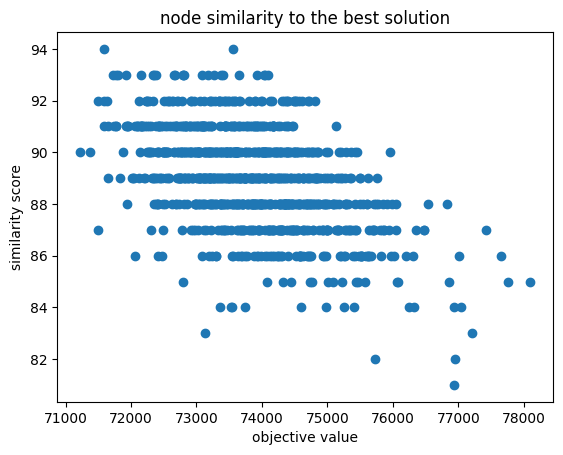

correlation value: -0.5045976193416439


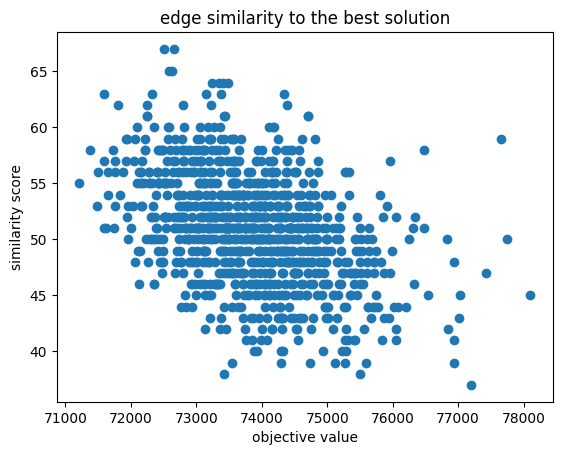

correlation value: -0.42185260742506514


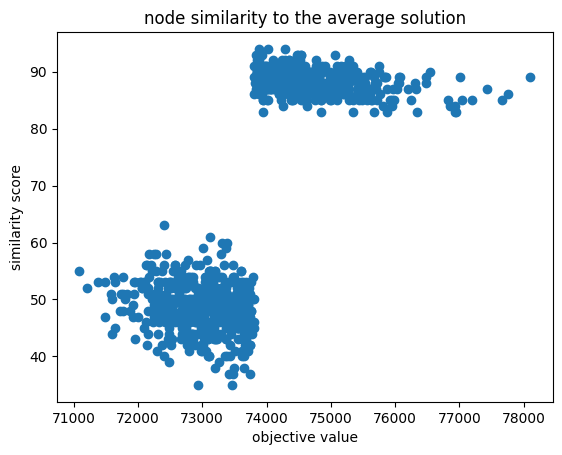

correlation value: 0.7516101695345767


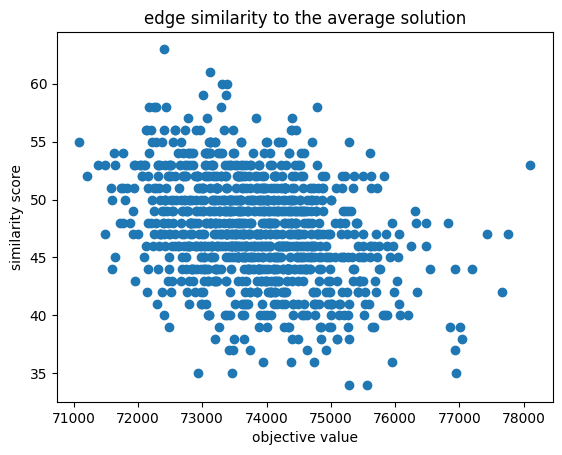

correlation value: -0.33615749700024344


In [25]:
examine_results(dist, costs, neighborhood, 1000)

In [26]:
n = 200
interNeighborhoodb = InterNeighborhood(distb, costsb, n // 2)
edgeNeighborhoodb = EdgeNeighborhood(distb, costsb, n // 2)
neighborhoodb = CombinedNeighborhood([edgeNeighborhoodb, interNeighborhoodb])

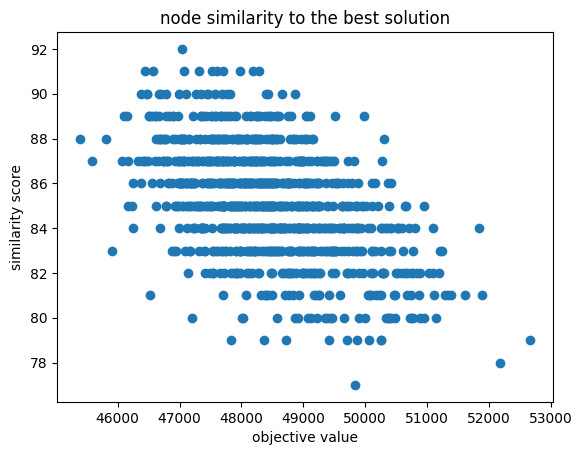

correlation value: -0.500661764217484


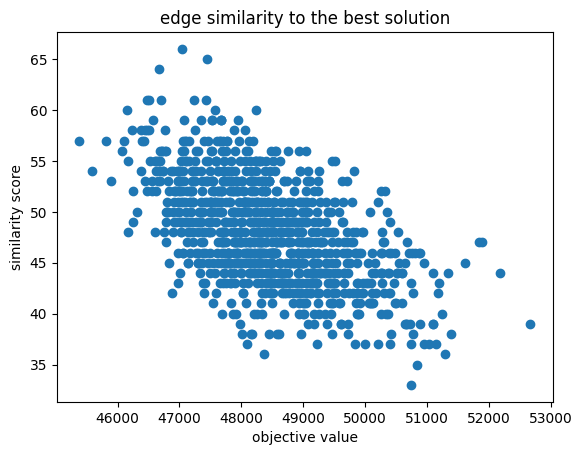

correlation value: -0.561822328880077


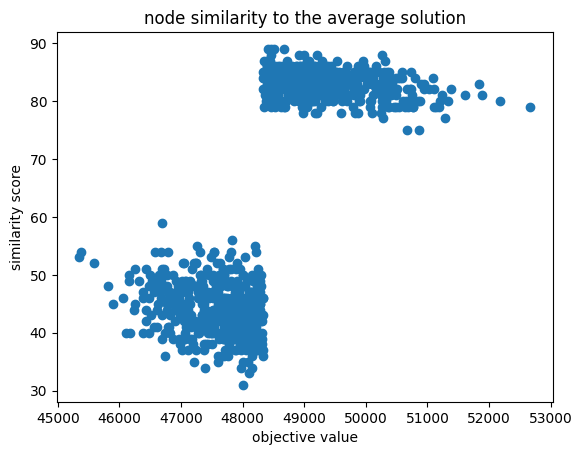

correlation value: 0.747207441070938


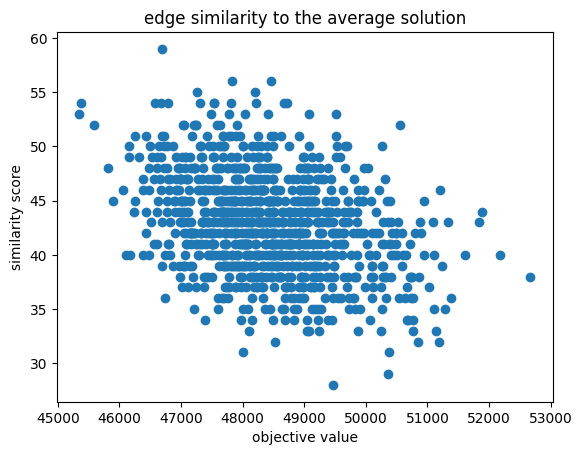

correlation value: -0.3401513201684792


In [27]:
examine_results(distb, costsb, neighborhoodb, 1000)